## Create and test ion channel model

In [1]:
from experiments.ina_sakakibara import (sakakibara_iv,
                                        sakakibara_iv_Nao2 ,
                                        sakakibara_iv_Nao5 ,
                                        sakakibara_iv_Nao20 ,
                                        sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_1,
                                        sakakibara_inact_kin_2,
                                        sakakibara_inact_kin_80,
                                        sakakibara_inact_kin_100,
                                        sakakibara_recov,
                                        sakakibara_recov_100,
                                        sakakibara_recov_kin)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.4


In [2]:
modelfile = 'models/ina_simple.mmt'

In [3]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_iv,
                                                sakakibara_act,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_1,
                                                sakakibara_recov_100,
                                                sakakibara_inact_kin_100)

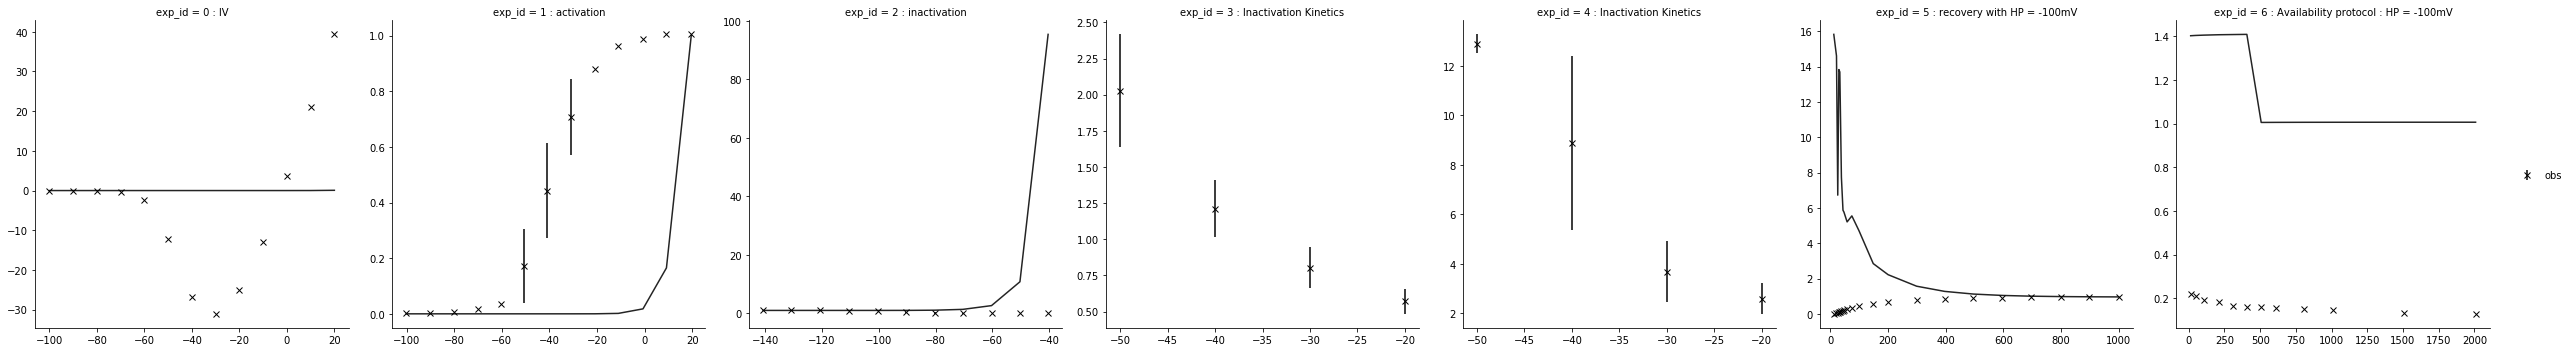

In [4]:
plot_sim_results(modelfile,sakakibara_iv,
                                                sakakibara_act,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_1,
                                                sakakibara_recov_100,
                                                sakakibara_inact_kin_100,n_samples=1) 

In [5]:
assert len(observations)==len(summary_statistics(model({})))

In [6]:
print(summary_statistics(model({})))

{'0': -9.101553540234432e-19, '1': -7.341957122335032e-17, '2': -3.911379719596589e-15, '3': -1.306764665763195e-13, '4': -3.4473974462911727e-12, '5': -8.32114001935444e-11, '6': -1.3172980844124888e-09, '7': -1.856431065688534e-08, '8': -2.3453481270581086e-07, '9': -1.5505064829605991e-06, '10': -1.953817299158355e-09, '11': 0.00017521192813777685, '12': 0.0016407581278029685, '13': 7.913506196207558e-17, '14': 8.181323264096925e-15, '15': 5.205316866808129e-13, '16': 2.4374066015217884e-11, '17': 8.350705875642132e-10, '18': 2.1934046411132165e-08, '19': 4.623651900164625e-07, '20': 8.073251218743828e-06, '21': 0.00012025347155891727, '22': 0.0015654767313710064, '23': 0.017776244783197264, '24': 0.16432618480623498, '25': 0.9953739993380764, '26': 0.9975858422617265, '27': 0.9969682587379822, '28': 0.9959739639827963, '29': 0.9947577220701153, '30': 0.9949711079039788, '31': 1.007992276400261, '32': 1.073991026369795, '33': 1.3561891299432867, '34': 2.633695447562553, '35': 10.772

## Set limits and generate uniform initial priors

In [14]:
df.describe()

name,ina.p_10,ina.p_2,ina.p_4,ina.p_6,ina.p_8,log_ina.g_Na,log_ina.p_1,log_ina.p_3,log_ina.p_5,log_ina.p_7,log_ina.p_9
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.076633,0.120191,0.062255,0.025980,0.125160,0.274242,2.602455,-2.668559,0.527656,-6.859782,0.598426
std,0.004887,0.009565,0.023390,0.003013,0.003351,0.028768,0.169710,0.837124,0.054093,0.103201,0.105429
min,0.059599,0.089159,0.000354,0.017221,0.113834,0.192652,2.130149,-5.013832,0.367750,-6.999902,0.235128
25%,0.073697,0.113630,0.044897,0.023882,0.123035,0.254931,2.480070,-3.252839,0.489408,-6.938461,0.536176
50%,0.077250,0.120136,0.064936,0.026125,0.125311,0.273655,2.608645,-2.669283,0.528912,-6.881844,0.613486
75%,0.080171,0.127078,0.081608,0.028224,0.127446,0.294670,2.728399,-2.105349,0.565033,-6.805325,0.676215
max,0.086804,0.146189,0.099972,0.033210,0.134355,0.370927,2.999366,-0.466762,0.680977,-6.395849,0.812789


In [15]:

limits = {'ina.A' : (0,1),
    'log_ina.g_Na' : (0.242,0.298),
'log_ina.p_1' :(2.43,2.77),
'ina.p_2' : (0.11,0.13),
'log_ina.p_3' : (-3.5,-1.84),
'ina.p_4' : (0.039,0.085),
'log_ina.p_5' : (0.48,0.58),
'ina.p_6' : (0.023,0.029),
'log_ina.p_7' : (-7.5,-6.76),
'ina.p_8' : (0.122,0.128),
'log_ina.p_9' : (0.498,0.698),
'ina.p_10' : (0.072,0.08) }

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [16]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "simple_ina_testing.db"))

In [17]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [18]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 4096 particles


In [19]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(4000), # Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=40),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.0130893232442144, '1': 1.0130893232442144, '2': 1.0130893232442144, '3': 1.0130893232442144, '4': 1.0130893232442144, '5': 1.0130893232442144, '6': 1.0130893232442144, '7': 1.0130893232442144, '8': 1.0130893232442144, '9': 1.0130893232442144, '10': 1.0130893232442144, '11': 1.0130893232442144, '12': 1.0130893232442144, '13': 1.0130893232442144, '14': 1.0130893232442144, '15': 1.0130893232442144, '16': 1.0130893232442144, '17': 1.0130893232442144, '18': 0.3841947300221712, '19': 0.2989019936587578, '20': 0.37151395423758, '21': 1.0130893232442144, '22': 1.0130893232442144, '23': 1.0130893232442144, '24': 1.0130893232442144, '25': 1.0130893232442144, '26': 1.1972873820158896, '27': 1.1972873820158896, '28': 1.1972873820158896, '29': 1.1972873820158896, '30': 1.1972873820158896, '31': 0.4490967622686441, '32': 0.2790873977407645, '33': 0.3091181614568887, '34': 0.77118475929223, '35': 1.1972873820158896, '36': 1.1972873820158896, '37': 0.860132270336

In [20]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [21]:
#abc.load(db_path,12)

In [22]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=25, start_time=2019-08-25 11:58:59.831988, end_time=None)>


In [23]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 4039
DEBUG:Epsilon:new eps, t=1, eps=4.728346984807883
INFO:ABC:t:1 eps:4.728346984807883
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 11860
DEBUG:Epsilon:new eps, t=2, eps=2.894392588883711
INFO:ABC:t:2 eps:2.894392588883711
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 19815
DEBUG:Epsilon:new eps, t=3, eps=2.307362718737435
INFO:ABC:t:3 eps:2.307362718737435
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 28002
DEBUG:Epsilon:new eps, t=4, eps=2.111099071893718
INFO:ABC:t:4 eps:2.111099071893718
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 36850
DEBUG:Epsilon:new eps, t=5, eps=2.0184843631201894


# Results analysis

/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/

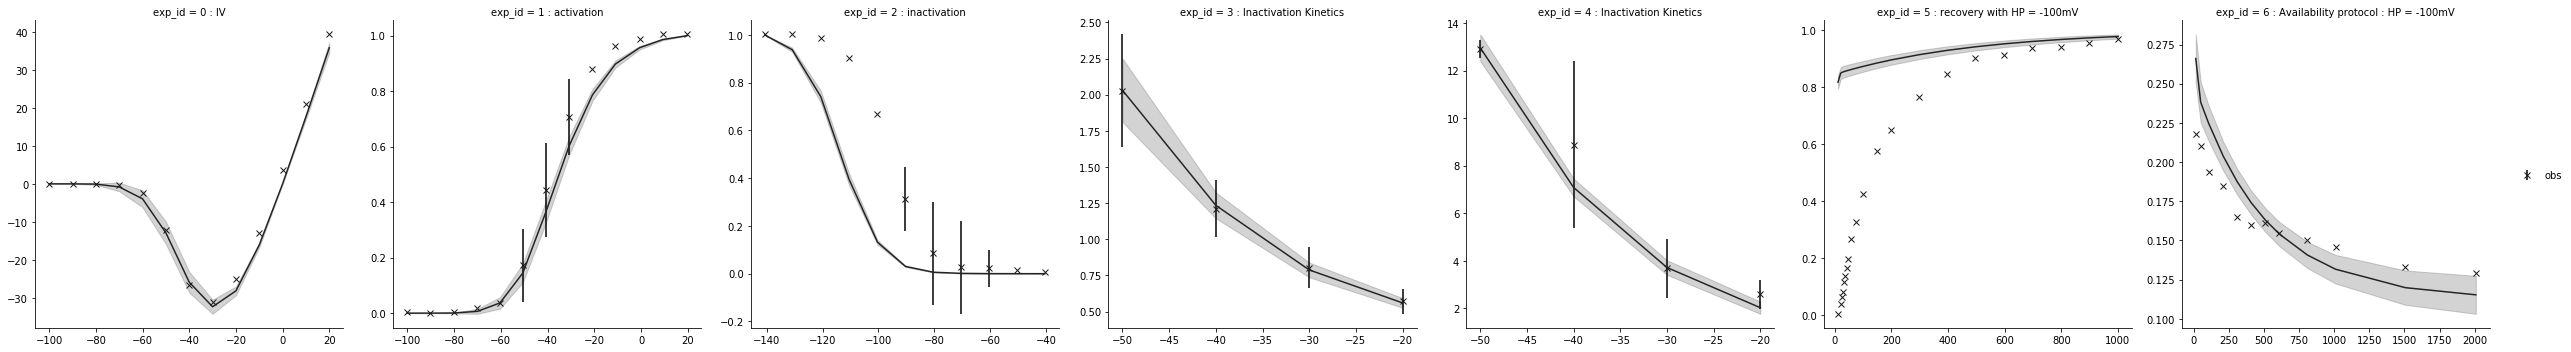

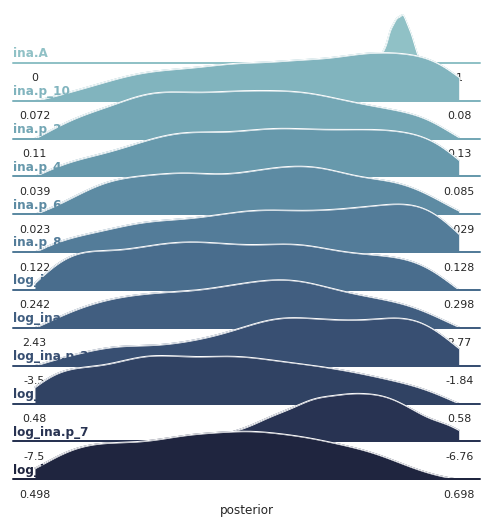

In [24]:
history = History(db_path)
history.id = 25  #5: pop size 10 to debug
# 8 : recovery sakakibara HP = -100 mV 
# 9 : availability HP = -80 mV
# 13 : time constants 
# 14 : IV 5 mM, act and inact
# 16 : all experiments
# 22 : all experiments with the gating parameter A : 6h for 1 iteartion and pop = 9M
# 24 : all experiments without the gating parameter A : 5/10 min with 40 cores for 1 iteartion and pop = 3.8M
# 25 : all experiments with the gating parameter A : the prior has been previously fixed to the result of id24
# we therefore retrieve the A = 0.9
# try at 
df, w = history.get_distribution(m=0)


grid1 = plot_sim_results(modelfile,sakakibara_iv,
                                                sakakibara_act,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_1,
                                                sakakibara_recov_100,
                                                sakakibara_inact_kin_100, df=df, w=w,n_samples=100) 
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)
#df.describe()

In [41]:
#grid1.savefig('results/Ina Simple model/ina_simple_all_exp_saka_pop_2000.pdf')
#grid2.savefig('results/Ina Simple model/ina_simple_all_post_saka_pop_2000.pdf')